In [1]:
import numpy as np
from scipy.special import gamma

import matplotlib.pyplot as plt

In [2]:
def linear_model(x, m, c):
    return m*x + c

### Generate data with Gaussian noise

\begin{align}
y = f(x) + n
\end{align}

Fetch some $\{y_i, x_i\}$. $n$ is a Gaussian.

In [3]:
injection_parameters = dict(m=0.8, c=2)

In [4]:
num_points = 100
x = np.linspace(-4, 4, num_points)

In [5]:
sigma = 0.6

In [6]:
# data = students_t_pdf(x, **injection_parameters) + np.random.normal(0, sigma, len(x))
data = linear_model(x, **injection_parameters) + np.random.normal(0, sigma, x.size)

Text(0, 0.5, 'y')

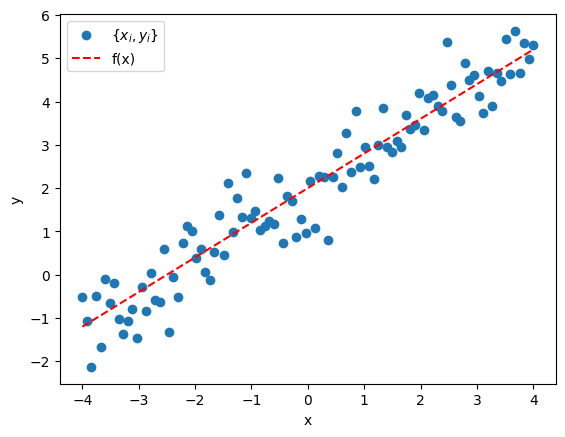

In [7]:
fig, ax = plt.subplots()
ax.plot(x, data, 'o', label='$\\{x_i, y_i\\}$')
# ax.plot(x, students_t_pdf(x, **injection_parameters), '--r', label='f(x)')
ax.plot(x, linear_model(x, **injection_parameters), '--r', label='f(x)')
ax.legend()
ax.set_xlabel('x')
ax.set_ylabel('y')

In [8]:
import bilby
from bilby.core.likelihood import GaussianLikelihood
from bilby.core.prior import Uniform, DeltaFunction

In [9]:
priors = dict()
# priors['mu'] = Uniform(-3, 3, name='mu', latex_label='m')
# priors['nu'] = DeltaFunction(injection_parameters['nu'], name='nu', latex_label='n')
# priors['sig'] = Uniform(0, 3, name='sig', latex_label='s')

# priors['m'] = DeltaFunction(injection_parameters['m'], name='m', latex_label='m')
priors['m'] = Uniform(-3, 3, name='m', latex_label='m')
priors['c'] = Uniform(-3, 3, name='c', latex_label='c')

# priors['sigma'] = Uniform(0, 1, name='sigma', latex_label='$\\sigma$')

In [10]:
# log_l = GaussianLikelihood(x, data, students_t_pdf, sigma=None)
log_l = GaussianLikelihood(x, data, linear_model, sigma=sigma)

In [11]:
result = bilby.run_sampler(
    likelihood=log_l, priors=priors, sampler='dynesty',
    nlive=300, npool=4, save=False, clean=True,
    injection_parameters=injection_parameters,
    outdir='./linear_regression',
    label='linear_regression'
)

# result = bilby.run_sampler(
#     likelihood=log_l, priors=priors, sampler='emcee',
#     nsamples=5000, save=False, clean=True,
#     injection_parameters=injection_parameters,
#     outdir='./student_t',
#     label='student_t'
# )

12:29 bilby INFO    : Running for label 'linear_regression', output will be saved to './linear_regression'
12:29 bilby INFO    : Analysis priors:
12:29 bilby INFO    : m=Uniform(minimum=-3, maximum=3, name='m', latex_label='m', unit=None, boundary=None)
12:29 bilby INFO    : c=Uniform(minimum=-3, maximum=3, name='c', latex_label='c', unit=None, boundary=None)
12:29 bilby INFO    : Analysis likelihood class: <class 'bilby.core.likelihood.GaussianLikelihood'>
12:29 bilby INFO    : Analysis likelihood noise evidence: nan
12:29 bilby INFO    : Single likelihood evaluation took 2.533e-05 s


0it [00:00, ?it/s]

12:29 bilby INFO    : Using sampler Dynesty with kwargs {'bound': 'multi', 'sample': 'rwalk', 'print_progress': True, 'periodic': None, 'reflective': None, 'check_point_delta_t': 1800, 'nlive': 300, 'first_update': None, 'walks': 100, 'npdim': None, 'rstate': None, 'queue_size': 4, 'pool': None, 'use_pool': None, 'live_points': None, 'logl_args': None, 'logl_kwargs': None, 'ptform_args': None, 'ptform_kwargs': None, 'enlarge': 1.5, 'bootstrap': None, 'vol_dec': 0.5, 'vol_check': 8.0, 'facc': 0.2, 'slices': 5, 'update_interval': 180, 'print_func': <bound method Dynesty._print_func of <bilby.core.sampler.dynesty.Dynesty object at 0x7fed24ec1550>>, 'dlogz': 0.1, 'maxiter': None, 'maxcall': None, 'logl_max': inf, 'add_live': True, 'save_bounds': False, 'n_effective': None, 'maxmcmc': 5000, 'nact': 5, 'print_method': 'tqdm'}
12:29 bilby INFO    : Checkpoint every check_point_delta_t = 600s
12:29 bilby INFO    : Using dynesty version 1.0.1
12:29 bilby INFO    : Using the bilby-implemented rw

<frozen importlib._bootstrap>:228: RuntimeWarning: numpy.ndarray size changed, may indicate binary incompatibility. Expected 16 from C header, got 96 from PyObject


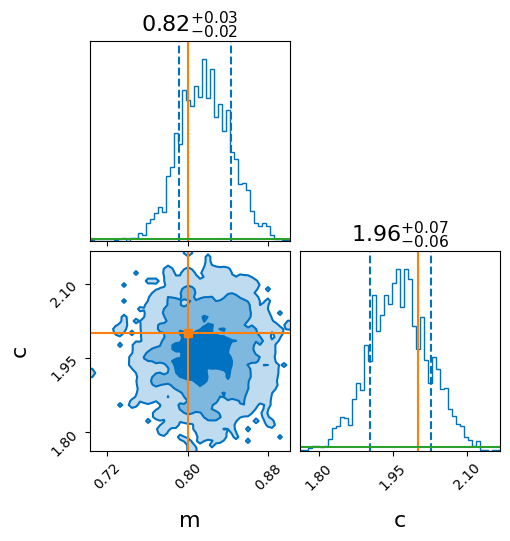

In [12]:
result.plot_corner(priors=True, quantiles=(0.16, 0.84))

In [13]:
sigma/np.sqrt(np.sum((x)**2))

0.025722240636584064

In [14]:
sigma * np.sqrt(1/num_points)

0.06

# Same problem by training a normalizing flow

In [15]:
from IPython.display import clear_output
from time import sleep

def live_plot_samples(samples, truth):
    clear_output(wait=True)
    sleep(1)
    figure = corner.corner(
        samples.numpy(), quantiles=[0.16, 0.5, 0.84],
        show_titles=True, labels=["m", "c"],
        truth=truth
    )

    corner.overplot_lines(figure, truth, color="C1")
    corner.overplot_points(figure, truth[None], marker="s", color="C1")


def live_plot_bilby_result(result, **kwargs):
    clear_output(wait=True)
    sleep(1)
    result.plot_corner(priors=True)

In [16]:
def get_data(m=None, c=None, num_points=1):
    """Sample m, c and return a batch of data with noise"""
    m = priors['m'].sample() if m is None else m
    c = priors['c'].sample() if c is None else c
    #x = 8 * (np.random.uniform(size=num_points) - 0.5)
    x = np.linspace(-4, 4, num_points)
    y = m*x + c
    y += sigma*np.random.normal(size=x.size)

    return x, y, m, c

# Generate simulations

In [17]:
from torch.utils.data import Dataset, DataLoader

In [18]:
import torch
import torch.nn.functional as F
from torch import nn, optim
from torch.utils.tensorboard import SummaryWriter

/home/deep/miniconda3/envs/a3d3-pe/lib/python3.9/site-packages/torch/utils/tensorboard/__init__.py:4: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if not hasattr(tensorboard, "__version__") or LooseVersion(
/home/deep/miniconda3/envs/a3d3-pe/lib/python3.9/site-packages/torch/utils/tensorboard/__init__.py:6: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  ) < LooseVersion("1.15"):


In [19]:
num_simulations = 10000
theta_vals = []
data_vals = []
for ii in range(num_simulations):
    x_val, y_val, m_val, c_val = get_data(num_points=100)
    data_vals.append(y_val)
    theta_vals.append([m_val, c_val])

In [20]:
theta_vals = torch.from_numpy(np.array(theta_vals)).to(torch.float32)
data_vals = torch.from_numpy(np.array(data_vals)).to(torch.float32)

In [21]:
class DataGenerator(Dataset):
    def __len__(self):
        return num_simulations

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        return theta_vals[idx], data_vals[idx]

In [22]:
dataset = DataGenerator()

In [23]:
train_set_size = int(0.8 * num_simulations)
val_set_size = int(0.1 * num_simulations)
test_set_size = int(0.1 * num_simulations)

train_data, val_data, test_data = torch.utils.data.random_split(
    dataset, [train_set_size, val_set_size, test_set_size])

In [24]:
train_data_loader = DataLoader(
    train_data, batch_size=20,
    shuffle=True
)

val_data_loader = DataLoader(
    val_data, batch_size=20,
    shuffle=True
)

test_data_loader = DataLoader(
    test_data, batch_size=1,
    shuffle=False
)

In [25]:
for theta, data in train_data_loader:
    break

In [26]:
theta.shape, data.shape

(torch.Size([20, 2]), torch.Size([20, 100]))

# MAF with std normal

In [27]:
import corner

from nflows.distributions import StandardNormal
from nflows.flows import Flow
from nflows.transforms.autoregressive import MaskedAffineAutoregressiveTransform
from nflows.transforms import AffineTransform, CompositeTransform, ReversePermutation, RandomPermutation

from nflows.transforms import IdentityTransform

import nflows.utils as torchutils

In [28]:
def standardizing_transform(batch_t):
    t_mean = torch.mean(batch_t)
    t_std = torch.std(batch_t, dim=1)
    t_std[t_std < 1e-6] = 1e-6
    
    return AffineTransform(shift=-t_mean / t_std, scale=1 / t_std)


class ContextEncoder(nn.Module):
    def __init__(self, num_hidden_layers=2, activation=torch.relu):
        super().__init__()
        self.num_hidden_layers = num_hidden_layers
        self.activation = activation

    def forward(self, x):
        x = nn.Linear(num_points, 50)(x)
        x = self.activation(x)
        for _ in range(self.num_hidden_layers):
            x = nn.Linear(50, 50)(x)
            x = self.activation(x)
        x = nn.Linear(50, 2)(x)
        return x

In [29]:
num_transforms = 5
num_blocks = 2
hidden_features = 50

# embedding_net = ContextEncoder(num_hidden_layers=2)
embedding_net = IdentityTransform()

context_features = embedding_net(data[:1])[0].numel()

base_dist = StandardNormal([theta[0].numel()])

# transforms = [AffineTransform(shift=0, scale=1)]
transforms = []

for _ in range(num_transforms):
    block = [
        MaskedAffineAutoregressiveTransform(
                features=theta[0].numel(),  # 2-dim posterior
                hidden_features=hidden_features,
                context_features=context_features,
                num_blocks=num_blocks,
                activation=torch.tanh,
                use_batch_norm=False,
                use_residual_blocks=False,
        ),
        RandomPermutation(features=theta[0].numel())
    ]
    transforms += block

transform = CompositeTransform(transforms)

flow = Flow(transform, base_dist)
# flow = Flow(transform, base_dist, embedding_net)

optimizer = optim.Adam(flow.parameters(), lr=1e-4)
# optimizer = optim.SGD(flow.parameters(), lr=1e-4, momentum=0.9)

scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)

# Train/Validate

In [30]:
def train_one_epoch(epoch_index, tb_writer):
    running_loss = 0.
    last_loss = 0.

    for idx, val in enumerate(train_data_loader, 1):
        theta, data = val
        
        optimizer.zero_grad()
        loss = -flow.log_prob(theta, context=data).sum()
        loss.backward()
        optimizer.step()
        # Gather data and report
        running_loss += loss.item()
        if idx % 100 == 0:
            last_loss = running_loss / 100 # avg loss per batch after 1000 batches
            print(' Avg. train loss/batch after {} batches = {:.4f}'.format(idx, last_loss))
            tb_x = epoch_index * len(train_data_loader) + idx
            tb_writer.add_scalar('Loss/train', last_loss, tb_x)
            tb_writer.flush()
            running_loss = 0.
    return last_loss


def val_one_epoch(epoch_index, tb_writer):
    running_loss = 0.
    last_loss = 0.

    for idx, val in enumerate(val_data_loader, 1):
        theta_val, data_val = val

        loss = -flow.log_prob(theta_val, context=data_val).sum()
        running_loss += loss.item()

        if idx % 50 == 0:
            last_loss = running_loss / 50
            tb_x = epoch_index * len(val_data_loader) + idx + 1
            tb_writer.add_scalar('Loss/val', last_loss, tb_x)
            tb_writer.flush()
            running_loss = 0.
    tb_writer.flush()
    return last_loss

In [31]:
flow

Flow(
  (_transform): CompositeTransform(
    (_transforms): ModuleList(
      (0): MaskedAffineAutoregressiveTransform(
        (autoregressive_net): MADE(
          (initial_layer): MaskedLinear(in_features=2, out_features=50, bias=True)
          (context_layer): Linear(in_features=100, out_features=50, bias=True)
          (blocks): ModuleList(
            (0): MaskedFeedforwardBlock(
              (linear): MaskedLinear(in_features=50, out_features=50, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (1): MaskedFeedforwardBlock(
              (linear): MaskedLinear(in_features=50, out_features=50, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (final_layer): MaskedLinear(in_features=50, out_features=4, bias=True)
        )
      )
      (1): RandomPermutation()
      (2): MaskedAffineAutoregressiveTransform(
        (autoregressive_net): MADE(
          (initial_layer): MaskedLinear(i

In [32]:
writer = SummaryWriter("linear_regression_again", comment="With LR=1e-4", flush_secs=5)
epoch_number = 0

In [33]:
%%time
EPOCHS = 100

for epoch in range(EPOCHS):
    print('EPOCH {}:'.format(epoch_number + 1))
    # Gradient tracking
    flow.train(True)
    avg_train_loss = train_one_epoch(epoch_number, writer)
    
    # no gradient tracking, for validation
    flow.train(False)
    avg_val_loss = val_one_epoch(epoch_number, writer)
    
    print(f"Train/Val Loss after epoch: {avg_train_loss:.4f}/{avg_val_loss:.4f}")
    epoch_number += 1
    scheduler.step()

EPOCH 1:
 Avg. train loss/batch after 100 batches = 90.7490
 Avg. train loss/batch after 200 batches = 46.8461
 Avg. train loss/batch after 300 batches = 15.5086
 Avg. train loss/batch after 400 batches = -3.5842
Train/Val Loss after epoch: -3.5842/-10.2712
EPOCH 2:
 Avg. train loss/batch after 100 batches = -14.0349
 Avg. train loss/batch after 200 batches = -18.3232
 Avg. train loss/batch after 300 batches = -21.9343
 Avg. train loss/batch after 400 batches = -24.7971
Train/Val Loss after epoch: -24.7971/-25.6343
EPOCH 3:
 Avg. train loss/batch after 100 batches = -26.9987
 Avg. train loss/batch after 200 batches = -29.3778
 Avg. train loss/batch after 300 batches = -29.9703
 Avg. train loss/batch after 400 batches = -32.0152
Train/Val Loss after epoch: -32.0152/-32.6984
EPOCH 4:
 Avg. train loss/batch after 100 batches = -33.8377
 Avg. train loss/batch after 200 batches = -34.8709
 Avg. train loss/batch after 300 batches = -35.0347
 Avg. train loss/batch after 400 batches = -35.1378

 Avg. train loss/batch after 200 batches = -55.8657
 Avg. train loss/batch after 300 batches = -55.7254
 Avg. train loss/batch after 400 batches = -56.5271
Train/Val Loss after epoch: -56.5271/-52.5954
EPOCH 33:
 Avg. train loss/batch after 100 batches = -56.6922
 Avg. train loss/batch after 200 batches = -56.0177
 Avg. train loss/batch after 300 batches = -56.2960
 Avg. train loss/batch after 400 batches = -56.1641
Train/Val Loss after epoch: -56.1641/-52.2222
EPOCH 34:
 Avg. train loss/batch after 100 batches = -55.9718
 Avg. train loss/batch after 200 batches = -56.5554
 Avg. train loss/batch after 300 batches = -56.9909
 Avg. train loss/batch after 400 batches = -56.6061
Train/Val Loss after epoch: -56.6061/-51.5544
EPOCH 35:
 Avg. train loss/batch after 100 batches = -56.8009
 Avg. train loss/batch after 200 batches = -56.5765
 Avg. train loss/batch after 300 batches = -56.5683
 Avg. train loss/batch after 400 batches = -56.5213
Train/Val Loss after epoch: -56.5213/-52.6439
EPOCH 

 Avg. train loss/batch after 300 batches = -58.2744
 Avg. train loss/batch after 400 batches = -58.0831
Train/Val Loss after epoch: -58.0831/-53.6889
EPOCH 64:
 Avg. train loss/batch after 100 batches = -58.5682
 Avg. train loss/batch after 200 batches = -58.0995
 Avg. train loss/batch after 300 batches = -59.0567
 Avg. train loss/batch after 400 batches = -58.5123
Train/Val Loss after epoch: -58.5123/-53.3573
EPOCH 65:
 Avg. train loss/batch after 100 batches = -58.6661
 Avg. train loss/batch after 200 batches = -58.5072
 Avg. train loss/batch after 300 batches = -58.5657
 Avg. train loss/batch after 400 batches = -58.6664
Train/Val Loss after epoch: -58.6664/-53.6273
EPOCH 66:
 Avg. train loss/batch after 100 batches = -59.5962
 Avg. train loss/batch after 200 batches = -57.8797
 Avg. train loss/batch after 300 batches = -58.4274
 Avg. train loss/batch after 400 batches = -58.3812
Train/Val Loss after epoch: -58.3812/-53.4929
EPOCH 67:
 Avg. train loss/batch after 100 batches = -58.8

 Avg. train loss/batch after 400 batches = -58.9904
Train/Val Loss after epoch: -58.9904/-53.8354
EPOCH 95:
 Avg. train loss/batch after 100 batches = -58.8099
 Avg. train loss/batch after 200 batches = -58.4568
 Avg. train loss/batch after 300 batches = -59.7374
 Avg. train loss/batch after 400 batches = -59.0555
Train/Val Loss after epoch: -59.0555/-53.6605
EPOCH 96:
 Avg. train loss/batch after 100 batches = -59.1907
 Avg. train loss/batch after 200 batches = -58.9774
 Avg. train loss/batch after 300 batches = -58.9043
 Avg. train loss/batch after 400 batches = -59.0225
Train/Val Loss after epoch: -59.0225/-53.8104
EPOCH 97:
 Avg. train loss/batch after 100 batches = -58.4782
 Avg. train loss/batch after 200 batches = -59.1985
 Avg. train loss/batch after 300 batches = -59.4216
 Avg. train loss/batch after 400 batches = -58.9919
Train/Val Loss after epoch: -58.9919/-53.7761
EPOCH 98:
 Avg. train loss/batch after 100 batches = -59.6791
 Avg. train loss/batch after 200 batches = -58.9

# Check on test data

In [34]:
import pandas as pd

def cast_as_bilby_result(samples, truth):
    injections = dict.fromkeys(injection_parameters)
    injections['m'] = float(truth.numpy()[0])
    injections['c'] = float(truth.numpy()[1])

    posterior = dict.fromkeys(injection_parameters)
    samples_numpy = samples.numpy()
    posterior['m'] = samples_numpy.T[0].flatten()
    posterior['c'] = samples_numpy.T[1].flatten()
    posterior = pd.DataFrame(posterior)
    
    return bilby.result.Result(
        label="test_data",
        injection_parameters=injections,
        posterior=posterior,
        search_parameter_keys=list(injections.keys()),
        priors=priors
    )

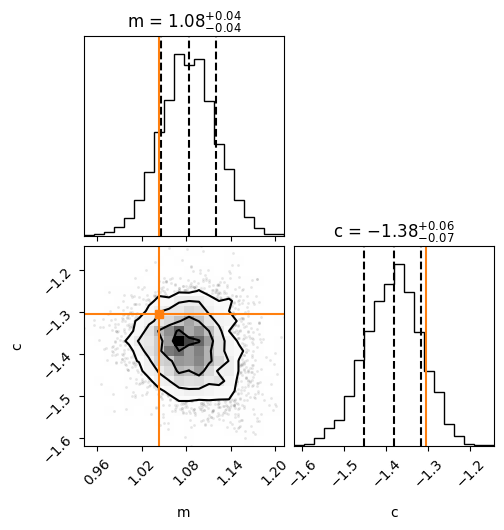

In [35]:
for idx, (theta_test, data_test) in enumerate(test_data):
    if idx == 20: break 
    with torch.no_grad():
        samples = flow.sample(5000, context=data_test.reshape((1, 100)))
    #live_plot_bilby_result(cast_as_bilby_result(samples, theta_test))
    live_plot_samples(samples, theta_test)
    plt.show()

# PP plot

In [36]:
results = []
for idx, (theta_test, data_test) in enumerate(test_data):
    with torch.no_grad():
        samples = flow.sample(5000, context=data_test.reshape((1, 100)))
    results.append(
        cast_as_bilby_result(samples, theta_test))

12:32 bilby INFO    : Key: KS-test p-value
12:32 bilby INFO    : m: 0.024240947545634328
12:32 bilby INFO    : c: 0.17816339237063894
12:32 bilby INFO    : Combined p-value: 0.027833975139500297


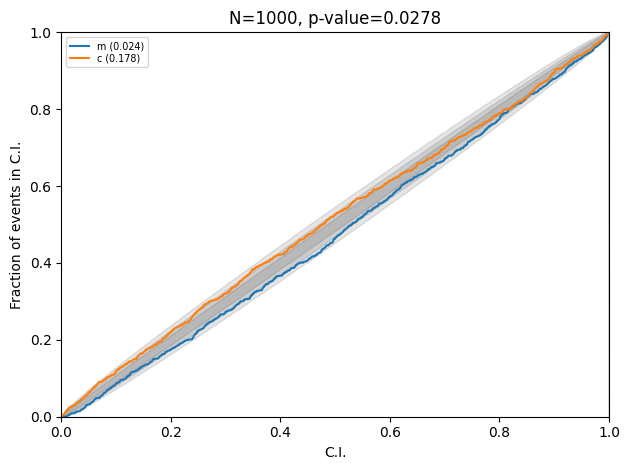

In [37]:
import warnings
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    bilby.result.make_pp_plot(results, save=False, keys=['m', 'c'])